In [1]:
import os
import numpy as np
import cv2
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def get_pixel(img, center, x, y, bita=0.1):
    """
    Get the pixel value of the image at coordinates x and y.
    """
    try:
        return img[x, y]
    except IndexError:
        # For pixels outside the image boundaries, return the intensity of the center pixel
        return center

def thresholded(center, pixels, bita=0.1):
    """
    Compare pixel values around the center pixel.
    """
    lower_bound = center * (1 - bita)
    upper_bound = center * (1 + bita)
    
    output = []
    for pixel in pixels:
        if lower_bound <= pixel <= upper_bound:
            output.append(1)
        else:
            output.append(0)
    return output

def compute_albp_pixel(img, x, y, bita=0.1):
    """
    Compute the ALBP value of a single pixel.
    """
    center = img[x, y]
    pixels = [
        get_pixel(img, center, x+1, y-1, bita),
        get_pixel(img, center, x, y-1, bita),
        get_pixel(img, center, x-1, y-1, bita),
        get_pixel(img, center, x-1, y, bita),
        get_pixel(img, center, x-1, y+1, bita),
        get_pixel(img, center, x, y+1, bita),
        get_pixel(img, center, x+1, y+1, bita),
        get_pixel(img, center, x+1, y, bita)
    ]
    values = thresholded(center, pixels, bita)
    res = 0
    for i in range(len(values)):
        res += values[i] * (2**i)
    return res

def compute_albp_image(image, bita=0.1):
    """
    Compute the ALBP image.
    """
    # Convert the image to grayscale if it's not already
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Initialize the ALBP image with zeros
    albp_image = np.zeros_like(image)
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            albp_image[i, j] = compute_albp_pixel(image, i, j, bita)
    return albp_image


In [3]:
# Data directories for different classes
class_directories = {
    'Cyst': '/kaggle/input/kidney-ct-scan-clahe/Cyst',
    'Normal': '/kaggle/input/kidney-ct-scan-clahe/Normal',
    'Stone': '/kaggle/input/kidney-ct-scan-clahe/Stone',
    'Tumor': '/kaggle/input/kidney-ct-scan-clahe/Tumor'
}

In [4]:
# List to store ALBP features and corresponding labels
albp_features = []
labels = []

In [5]:
# Iterate over each class directory
for class_label, directory in class_directories.items():
    # List all image files in the directory
    image_files = [os.path.join(directory, file) for file in os.listdir(directory)]
    
    # Extract ALBP features for each image and store them in the list
    for image_file in image_files:
        image = cv2.imread(image_file)
        albp_feature = compute_albp_image(image)
        albp_features.append(albp_feature.ravel())
        labels.append(class_label)

In [6]:
# Convert lists to numpy arrays
albp_features = np.array(albp_features)
labels = np.array(labels)

In [7]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(albp_features, labels, test_size=0.2, random_state=42)


In [8]:
# Initialize classifiers
dt_classifier = DecisionTreeClassifier(random_state=42)
rf_classifier = RandomForestClassifier(random_state=42)
knn_classifier = KNeighborsClassifier()
svc_classifier = SVC(probability=True, random_state=42)
nb_classifier = GaussianNB()

In [9]:
# Create the ensemble model with soft voting
ensemble_classifier = VotingClassifier(estimators=[
    ('decision_tree', dt_classifier),
    ('random_forest', rf_classifier),
    ('k_nearest_neighbors', knn_classifier),
    ('support_vector_machine', svc_classifier),
    ('naive_bayes', nb_classifier)
], voting='soft')

In [10]:
# Fit the ensemble model on the training data
ensemble_classifier.fit(X_train, y_train)

VotingClassifier(estimators=[('decision_tree',
                              DecisionTreeClassifier(random_state=42)),
                             ('random_forest',
                              RandomForestClassifier(random_state=42)),
                             ('k_nearest_neighbors', KNeighborsClassifier()),
                             ('support_vector_machine',
                              SVC(probability=True, random_state=42)),
                             ('naive_bayes', GaussianNB())],
                 voting='soft')

In [11]:

# Predict the labels for the test data
y_pred = ensemble_classifier.predict(X_test)

In [12]:

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9947791164658635


In [13]:
# Generate and print classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

        Cyst       1.00      1.00      1.00       765
      Normal       0.99      1.00      1.00      1015
       Stone       1.00      0.97      0.98       276
       Tumor       1.00      0.99      0.99       434

    accuracy                           0.99      2490
   macro avg       1.00      0.99      0.99      2490
weighted avg       0.99      0.99      0.99      2490



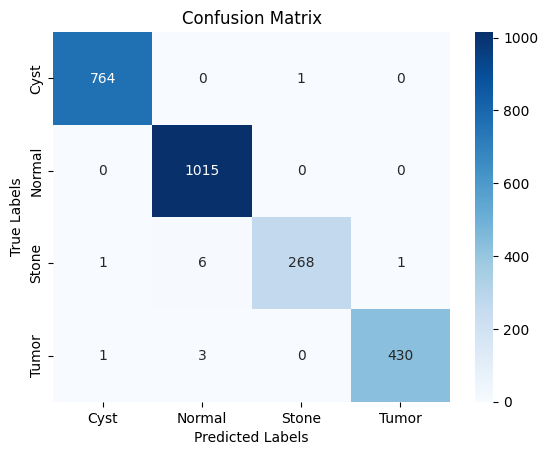

In [14]:
# Generate and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_directories.keys(), yticklabels=class_directories.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

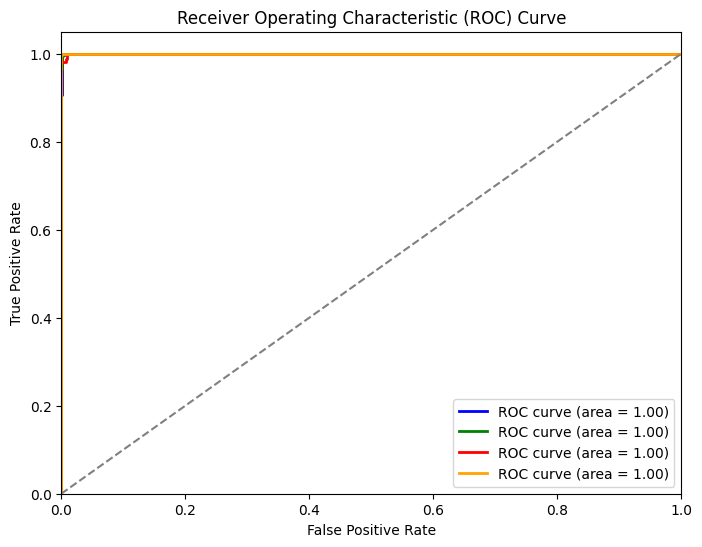

In [15]:
# Binarize the labels
y_test_bin = label_binarize(y_test, classes=['Cyst', 'Normal', 'Stone', 'Tumor'])

# Predict probabilities for each class
y_score = ensemble_classifier.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_bin.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
colors = ['blue', 'green', 'red', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve (area = %0.2f)' % roc_auc[i])

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()